# FEniCS simulation of a cantilever beam

The aim of this notebook is to setup a very simple FEniCS simulation. The framework is linear, plane strain elasticity. We model a cantilever beam ($L$: total length; $d$: depth), subjected to its own weight ($\rho$: mass density per unit volume; $g$: gravity).

The beam is homogenous and isotropic ($E$: Young modulus; $\nu$: Poisson ratio) and clamped on the left end. Hooke's law reads

\begin{equation}
\sigma_{ij} = \lambda\varepsilon_{kk}\delta_{ij}+2\mu\varepsilon_{ij},
\end{equation}

where indices $i, j, k$ are restricted to $\{1, 2\}$ and $\lambda$, $\mu$ are the Lamé coefficients :

\begin{equation*}
\mu=\frac{E}{2\bigl(1+\nu\bigr)}
\quad\text{and}\quad
\lambda=\frac{2\mu\nu}{1-2\nu}.
\end{equation*}

**Question:** how does Hooke's law read in *plane stress* elasticity?

The variational formulation of the problem is the following:

Find $u\in \mathcal{C}\equiv\{u: H^1(\Omega), \; u(x_1=0,x_2)=0\}$ such that 
$\forall v\in \mathcal{C}_0\equiv \mathcal{C}$


\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y =
-\int_{\Omega}\rho g\,e_y\cdot v\,\mathrm{d} x\,\mathrm{d} y,
\end{equation}

where $\sigma(\varepsilon)$ is the constitutive equation and $\varepsilon(u)=\mathrm{sym} (\nabla u)$  

Remark: we work with only one unknown vector field, the displacement $\{u_x(x_1,x_2),u_y(x_1,x_2)\}$

![image of beam](cantilever_beam.png "Cantilever beam")

In [1]:
import dolfinx # FEM in python
#import matplotlib.pyplot as plt
import ufl # variational formulations
import numpy as np
#from mpi4py import MPI
import mpi4py
from petsc4py.PETSc import ScalarType

This tutorial

https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity_code.html

is in 3D. Please adapt it in the present 2D case.

## 1) Start with defining the mesh

In [2]:
# geometry and mesh 
L = 1. # total length
d = L/10. # thickness
h = d/6. # size of a cell


In [3]:
from dolfinx import mesh, fem, plot, io

domain = mesh.create_rectangle(mpi4py.MPI.COMM_WORLD, [np.array([0,0]), np.array([L, d])],
                  [int(L/h),int(d/h)], cell_type=mesh.CellType.quadrilateral)

V = fem.VectorFunctionSpace(domain, ('Lagrange', 1))



use 
```
dolfinx.mesh.create_rectangle()


with comm=mpi4py.MPI.COMM_WORLD
```
call your mesh : my_domain

Mesh image by pyvista


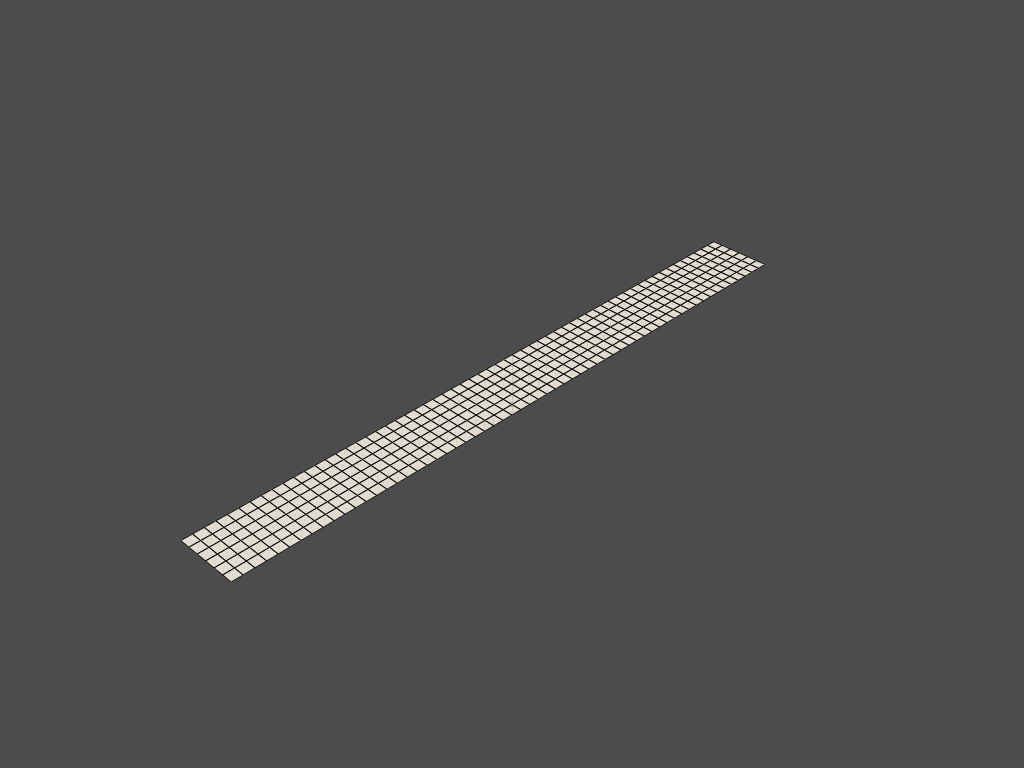

In [4]:
from dolfinx.plot import create_vtk_mesh
import pyvista
pyvista.start_xvfb()
#pyvista.set_jupyter_backend("pythreejs")
pyvista.set_jupyter_backend("none")

# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

## Set deflection values and add it to plotter
#grid.point_data["u"] = uh.x.array
#warped = grid.warp_by_scalar("u", factor=1)
#
plotter = pyvista.Plotter()
grid_0 = pyvista.UnstructuredGrid(topology, cell_types, x)
plotter.add_mesh(grid_0, show_edges=True)
#plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True, scalars="u",opacity=0.8)

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    pyvista.start_xvfb()
    plotter.screenshot("deflection.png")

In [5]:
# Now export the mesh to see it on Paraview

#with dolfinx.io.XDMFFile(domain.comm, "output/output.xdmf", "w") as xdmf:
 #  xdmf.write_mesh(domain)
  # xdmf.write_function(V)
    
with dolfinx.io.XDMFFile(domain.comm, "out/mesh.xdmf", "w") as file:
    file.write_mesh(domain)

## 2) Choose an element (Lagrange of degree 1)

use

```
FunctionSpace( )
```

or ? 

```
VectorFunctionSpace( )
```

In [6]:
#Was done in cell 3

## 3) Define the strain

$u_i$ is  the displacement vector (note: $u=u(x_1,x_2)$)

and 

$\epsilon_{ij} = \frac12\bigl(\partial_i u_j+\partial_j u_i\bigr)$ is the strain tensor.

In [7]:
# use def to define the fonction epsilon = epsilon(u), just like
u = ufl.TrialFunction(V)

def epsilon(u):
    return ufl.sym(ufl.grad(u)) # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)


## 4) Write down Hooke's law

The Hooke's law with Lame's coefficeants :



Lame's coefficeants : 

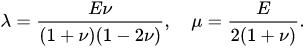

Plane stress 

\begin{equation}
\sigma_{11}=(2\mu+\lambda)\varepsilon_{11}+\mu\varepsilon_{33}+\mu\varepsilon_{22},
\sigma_{12}=2\mu\varepsilon_{12},
\end{equation}


In [11]:
# here we use the values
E = 1.0
nu = 0.3
lambda_coef=E*nu/((1+nu)*(1-2*nu))
mu=E/(2*(1+nu))


# Hook's law is written as the top of this notebook
def sigma(u) :
        
    return lambda_coef*ufl.nabla_div(u)*ufl.Identity(u.geometric_dimension())+2*mu*epsilon(u)
    #return lambda_coef*ufl.tr(epsilon(u))*ufl.Identity(u.geometric_dimension())+2*mu*epsilon(u)

#def sigma(epsilon):
#    return lambda_coef*ufl.inner(epsilon(u), I)*I+2*mu*epsilon
    


## 5) Name `u` the `TrialFunction` and `u_bar` the `TestFunction`

In [12]:
#u = ufl.TrialFunction(V) already done in chapter 3
u_bar = ufl.TestFunction(V)

## 6) Introduce the bilinear form
\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(\bar{u})\,\mathrm{d}x\,\mathrm{d}y
\end{equation}

What is the difference between `dolfin.dot( )` and `dolfin.inner( )` ?

In [13]:
a = ufl.inner(sigma(u), epsilon(u_bar)) * ufl.dx


#T = fem.Constant(domain, ScalarType((0, 0)))
#ds = ufl.Measure("ds", domain=domain)
#E_def = ufl.inner(sigma(u), epsilon(v)) * ufl.dx

## 7) Introduce the linear form

\begin{equation}
-\int_{\Omega}\rho g\,e_y\cdot \bar{v}\,\mathrm{d} x\,\mathrm{d} y.
\end{equation}

In [15]:
# here we use the value
g=0.01
rho = 1

f = dolfinx.fem.Constant(domain, ScalarType((0, -rho*g)))
L1 = ufl.dot(f, u_bar) * ufl.dx

## 8)  Boundary conditions

Dirichelet Boundary Condition: $u(0,x_2)=0 \quad  \forall x_2 \in [-\frac{d}{2},\frac{d}{2}]$

As $x_1=0$ is not well defined in our mesh, we write 

$u(x_1,x_2)=0 \quad \forall x_1 \simeq 0  \text{ and } \forall x_2 \in [-\frac{d}{2},\frac{d}{2}]$


In [16]:
def clamped_boundary(x):
    return np.isclose(x[0], 0)

In [17]:
# the mesh is 2D (x,y), so the boundary is 1D
facets_dim =1

In [18]:
# this finds all the facets of the elements that are at the boundary
boundary_facets = dolfinx.mesh.locate_entities_boundary(domain, facets_dim, clamped_boundary)

In [19]:
# this gives the label of all the facets on the x_1 = 0 edge
print(boundary_facets)

[ 0  4 10 18 28 40]


In [20]:
# this finds the label of the degree of freedom for the nodes on the boundary facets
boundary_dofs = dolfinx.fem.locate_dofs_topological(V, facets_dim, boundary_facets)

In [21]:
print(boundary_dofs)

[ 0  1  4  8 13 19 26]


In [22]:
# the Dirichlet condition
u_D = np.array([0,0], dtype=ScalarType)

In [23]:
bc = dolfinx.fem.dirichletbc(u_D, boundary_dofs, V)

## 9) Solving the discretized problem

In [24]:
problem = dolfinx.fem.petsc.LinearProblem(a, L1, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
# the solution is 'u_solution'
u_solution = problem.solve()

## 10) Ploting the solution

In [25]:
unorm = u_solution.x.norm()
print("Solution vector norm:", unorm)
print('for E = 1.0, nu = 0.3, g=0.01, L=1.0, d=0.1, this norm should approxymatly be equal to 13.2')

Solution vector norm: 14.329953317689075
for E = 1.0, nu = 0.3, g=0.01, L=1.0, d=0.1, this norm should approxymatly be equal to 13.2


In [46]:
# To have a name in Paraview
u_solution.name = "displacement_vector"

In [47]:
# We export the mesh+solution to see it on Paraview
with dolfinx.io.XDMFFile(my_domain.comm, "out/solution.xdmf", "w") as file:
    file.write_mesh(my_domain)
    file.write_function(u_solution)

## 11) Ploting the solution using matplotlib

In [ ]:
import extract

In [ ]:
# here is the value of ux and uy at the point x=0.5, y=0.01
extract.solution(my_domain, u_solution, 0.5, 0.01)
# should be [0.016, -0.48]

In [ ]:
# We want to plot u_y(x,0) for x in (0;1)

In [ ]:
# we create two lists 
tol = 0.001 # Avoid hitting the outside of the domain
nbr_pts = 20 # number of plot points
liste_x = np.linspace(0 + tol, 1 - tol, nbr_pts) # I will plot for x in (0;1)
liste_y = 0*liste_x # I will plot for y = 0

In [ ]:
# Create a list containing the values of uy at these points
for i, x_i in enumerate(liste_x):
    # blabla
    # etc
    # ...

In [ ]:
# plot it
plt.plot(liste_x, ...)

## 12) We compare this u_y value to linear beam theory
$$H(x_1)=?= u_{y,fenicsX}(x_1,0)$$

$$ H(x_1) = H_\text{max} \, \left ( - \frac{1}{3} \, (x_1-1)^4 - \frac{4}{3} \, x_1 + \frac{1}{3} \right) $$

In [ ]:
# we introduce the coefficients
D=E*d**3/12./(1.-nu**2) # bending rigidity of an elastic plate
k=0.5 # unknown coefficient that we want to find (it is not equal to 0.5)
# you have to find the correct value for k !
Hmax = k*g*d/D # maximum vertical deflection, from linear 'beam' theory 

In [ ]:
Hmax

In [ ]:
x = np.linspace(0., L, num=150)

plt.plot(liste_x, # here liste fenics u_y #, "o", linewidth=2, label="FEniCSx")

H_formula = Hmax * (-1./3.*(x-1.)**4 - 4./3.*x + 1/3)
plt.plot(x, H_formula, label='Beam theory')
plt.xlabel('x',color='red',fontsize=15)
plt.ylabel('H(x,0)',color='red',fontsize=15)
plt.legend()

## Does this work, why ?

## 14) Using PVista

In [22]:
import pyvista
pyvista.set_jupyter_backend("none")

In [23]:
# Create pyvista grid
topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

In [32]:
# Create plotter
plotter = pyvista.Plotter()

In [ ]:
# we first add the grid
plotter.add_mesh(grid, show_edges=True, style="wireframe", color="k");
# Then we display the scene
plotter.show()

```
Can you add the solution ?
```